In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt



In [4]:
# Define paths
base_dir = "E:\dkd\project\giemsa"
positive_dir = os.path.join(base_dir, 'positive')
negative_dir = os.path.join(base_dir, 'negative')


In [5]:
# List all files
positive_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if os.path.isfile(os.path.join(positive_dir, f))]
negative_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if os.path.isfile(os.path.join(negative_dir, f))]


In [6]:
# Split the data
train_pos, test_pos = train_test_split(positive_files, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(negative_files, test_size=0.2, random_state=42)


In [7]:
# Create directories for training and testing data
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


In [8]:
train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')


In [9]:
os.makedirs(train_pos_dir, exist_ok=True)
os.makedirs(train_neg_dir, exist_ok=True)
os.makedirs(test_pos_dir, exist_ok=True)
os.makedirs(test_neg_dir, exist_ok=True)


In [10]:
# Copy files to the respective directories
for file in train_pos:
    shutil.copy(file, train_pos_dir)
for file in train_neg:
    shutil.copy(file, train_neg_dir)
for file in test_pos:
    shutil.copy(file, test_pos_dir)
for file in test_neg:
    shutil.copy(file, test_neg_dir)


In machine learning and deep learning tasks involving image data, ImageDataGenerator is a utility in Keras (a popular deep learning library) that helps with real-time data augmentation and normalization during model training. Here's how it works in the context of your example:

    Normalization (rescale=1./255):
        This parameter scales the pixel values of images. Since RGB pixel values typically range from 0 to 255, dividing by 255 normalizes these values to the range [0, 1]. Normalization helps in faster convergence during training and often improves model performance.

In [11]:
# ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



In [12]:

# Load train and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)



Found 26530 images belonging to 2 classes.


In [13]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 6633 images belonging to 2 classes.


In [14]:
# Build the model  1
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=test_generator
)


Epoch 1/3
830/830 [==============================] - 594s 715ms/step - loss: 0.3506 - accuracy: 0.8545 - val_loss: 0.2859 - val_accuracy: 0.8928
Epoch 2/3
830/830 [==============================] - 647s 780ms/step - loss: 0.2962 - accuracy: 0.8878 - val_loss: 0.2798 - val_accuracy: 0.8958
Epoch 3/3
830/830 [==============================] - 755s 910ms/step - loss: 0.2926 - accuracy: 0.8883 - val_loss: 0.2779 - val_accuracy: 0.8957


In [16]:
# Predict on the test set
test_generator.reset()
predictions = model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)



208/208 [==============================] - 43s 204ms/step


In [17]:
# True labels
true_labels = test_generator.classes


In [18]:
# Classification report
report = classification_report(true_labels, predictions, target_names=['negative', 'positive'])
print(report)


              precision    recall  f1-score   support

    negative       0.83      1.00      0.90      3303
    positive       1.00      0.79      0.88      3330

    accuracy                           0.90      6633
   macro avg       0.91      0.90      0.89      6633
weighted avg       0.91      0.90      0.89      6633



In [19]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
print(cm)


[[3296    7]
 [ 685 2645]]


In [20]:
# Sensitivity and Specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')


Sensitivity: 0.7942942942942943
Specificity: 0.9978807145019679


In [21]:
# AUROC
auc = roc_auc_score(true_labels, predictions)
print(f'AUROC: {auc}')



AUROC: 0.8960875043981311


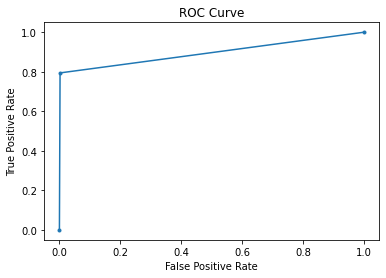

In [22]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [25]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


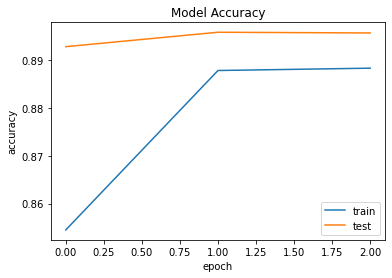

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy  plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

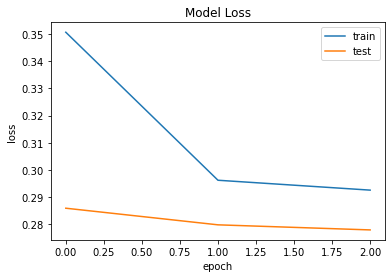

In [27]:
# Model Losss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [31]:
# Increased Filters and Different Kernel Sizes  : model2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model1 = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
# Train model2
history1 = model1.fit(train_generator, epochs=3, validation_data=test_generator)

Epoch 1/3
830/830 [==============================] - 2675s 3s/step - loss: 0.3875 - accuracy: 0.8409 - val_loss: 0.2990 - val_accuracy: 0.8776
Epoch 2/3
830/830 [==============================] - 2653s 3s/step - loss: 0.2772 - accuracy: 0.8864 - val_loss: 0.1476 - val_accuracy: 0.9435
Epoch 3/3
830/830 [==============================] - 2627s 3s/step - loss: 0.1477 - accuracy: 0.9458 - val_loss: 0.2743 - val_accuracy: 0.8964


In [35]:
# Predict on the test set
test_generator.reset()
predictions1 = model1.predict(test_generator)
predictions1 = (predictions1 > 0.5).astype(int)
# True labels
true_labels = test_generator.classes
# Classification report
report1 = classification_report(true_labels, predictions1, target_names=['negative', 'positive'])
print(report1)


208/208 [==============================] - 127s 609ms/step
              precision    recall  f1-score   support

    negative       0.84      0.98      0.90      3303
    positive       0.98      0.81      0.89      3330

    accuracy                           0.90      6633
   macro avg       0.91      0.90      0.90      6633
weighted avg       0.91      0.90      0.90      6633



In [36]:
# Confusion matrix
cm1 = confusion_matrix(true_labels, predictions1)
print(cm1)

# Sensitivity and Specificity
tn, fp, fn, tp = cm1.ravel()
sensitivity1 = tp / (tp + fn)
specificity1 = tn / (tn + fp)
print(f'Sensitivity: {sensitivity1}')
print(f'Specificity: {specificity1}')
# AUROC
auc1 = roc_auc_score(true_labels, predictions1)
print(f'AUROC: {auc1}')


[[3250   53]
 [ 634 2696]]
Sensitivity: 0.8096096096096096
Specificity: 0.9839539812291855
AUROC: 0.8967817954193975


In [37]:
#Model 3
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [38]:
# Train model2
history2 = model2.fit(train_generator, epochs=3, validation_data=test_generator)

Epoch 1/3
830/830 [==============================] - 718s 864ms/step - loss: 0.3264 - accuracy: 0.8657 - val_loss: 0.2854 - val_accuracy: 0.8934
Epoch 2/3
830/830 [==============================] - 767s 924ms/step - loss: 0.2725 - accuracy: 0.8913 - val_loss: 0.1401 - val_accuracy: 0.9522
Epoch 3/3
830/830 [==============================] - 778s 938ms/step - loss: 0.1612 - accuracy: 0.9400 - val_loss: 0.1411 - val_accuracy: 0.9352


In [46]:
# Predict on the test set
test_generator.reset()
predictions2 = model2.predict(test_generator)
predictions2 = (predictions2 > 0.5).astype(int)
# True labels
true_labels = test_generator.classes
# Classification report
report2 = classification_report(true_labels, predictions2, target_names=['negative', 'positive'])
print(report2)


208/208 [==============================] - 46s 219ms/step
              precision    recall  f1-score   support

    negative       0.89      0.99      0.94      3303
    positive       0.99      0.88      0.93      3330

    accuracy                           0.94      6633
   macro avg       0.94      0.94      0.94      6633
weighted avg       0.94      0.94      0.93      6633



In [47]:
# Confusion matrix
cm2 = confusion_matrix(true_labels, predictions2)
print(cm2)

# Sensitivity and Specificity
tn, fp, fn, tp = cm2.ravel()
sensitivity2 = tp / (tp + fn)
specificity2 = tn / (tn + fp)
print(f'Sensitivity: {sensitivity2}')
print(f'Specificity: {specificity2}')
# AUROC
auc2 = roc_auc_score(true_labels, predictions2)
print(f'AUROC: {auc2}')

[[3266   37]
 [ 393 2937]]
Sensitivity: 0.881981981981982
Specificity: 0.9887980623675446
AUROC: 0.9353900221747633


In [41]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [42]:
# Train model3
history3 = model3.fit(train_generator, epochs=3, validation_data=test_generator)

Epoch 1/3
830/830 [==============================] - 613s 738ms/step - loss: 0.2600 - accuracy: 0.8941 - val_loss: 0.1063 - val_accuracy: 0.9682
Epoch 2/3
830/830 [==============================] - 664s 799ms/step - loss: 0.1326 - accuracy: 0.9532 - val_loss: 0.0932 - val_accuracy: 0.9626
Epoch 3/3
830/830 [==============================] - 697s 839ms/step - loss: 0.0882 - accuracy: 0.9678 - val_loss: 0.0512 - val_accuracy: 0.9801


In [43]:
# Predict on the test set
test_generator.reset()
predictions3 = model3.predict(test_generator)
predictions3 = (predictions3 > 0.5).astype(int)
# True labels
true_labels = test_generator.classes
# Classification report
report3 = classification_report(true_labels, predictions3, target_names=['negative', 'positive'])
print(report3)

208/208 [==============================] - 39s 187ms/step
              precision    recall  f1-score   support

    negative       0.98      0.98      0.98      3303
    positive       0.98      0.98      0.98      3330

    accuracy                           0.98      6633
   macro avg       0.98      0.98      0.98      6633
weighted avg       0.98      0.98      0.98      6633



In [45]:
# Confusion matrix
cm3 = confusion_matrix(true_labels, predictions2)
print(cm3)

# Sensitivity and Specificity
tn, fp, fn, tp = cm3.ravel()
sensitivity3 = tp / (tp + fn)
specificity3 = tn / (tn + fp)
print(f'Sensitivity: {sensitivity3}')
print(f'Specificity: {specificity3}')
# AUROC
auc3 = roc_auc_score(true_labels, predictions3)
print(f'AUROC: {auc3}')

[[3250   53]
 [ 634 2696]]
Sensitivity: 0.8096096096096096
Specificity: 0.9839539812291855
AUROC: 0.9801126739818837
